***Import all the libraries***

In [1]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt  
from sklearn.model_selection import train_test_split
from sklearn import metrics
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import classification_report
# from sklearn.metrics import plot_confusion_matrix

***Add the dataset and drop the irrelevant columns***

In [2]:
df = pd.read_csv('../data/cases_train_processed.csv')

# Some preprocessing
df = df.drop(['latitude_x', 'longitude_x'], axis=1) # drop these columns with inconsistent/irrelevant data
df["date_confirmation"] = pd.to_datetime(df["date_confirmation"]).dt.strftime("%Y%m%d").astype(int) # convert date from object type to int type
df.head(5)

,age,sex,province,country,date_confirmation,additional_information,source,outcome,key,latitude_y,longitude_y,confirmed_sum,death_sum,recovered_sum,incidence_rate_avg,active_sum,Case-Fatality_Ratio
0,44.0,Unknown,Delhi,India,20200526,0,1,recovered,"Delhi, India",28.646519,77.108980,238828.0,4907.0,201671.0,1276.409575,32250.0,2.054617
1,44.0,Unknown,Uttar Pradesh,India,20200520,0,1,hospitalized,"Uttar Pradesh, India",26.925425,80.560982,342788.0,4869.0,270094.0,144.099577,67825.0,1.420411
2,44.0,Unknown,Maharashtra,India,20200526,0,1,hospitalized,"Maharashtra, India",19.449759,76.108221,1167496.0,31791.0,834432.0,948.072083,301273.0,2.723007
3,24.0,female,Baden-Wurttemberg,Germany,20200315,0,0,nonhospitalized,"Baden-Wurttemberg, Germany",48.661600,9.350100,46779.0,1871.0,41228.0,422.592353,3680.0,3.999658
4,44.0,Unknown,Gujarat,India,20200520,0,1,hospitalized,"Gujarat, India",22.694884,71.590923,120336.0,3286.0,100974.0,188.400627,16076.0,2.730687


# LightGBM Classifier
### Building the model
*First, convert all the categorical features into the category type which is used by LightGBM for processing categorical data.*

In [3]:
for c in df.columns:
    col_type = df[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        df[c] = df[c].astype('category')

df.dtypes

age                        float64
sex                       category
province                  category
country                   category
date_confirmation            int64
additional_information       int64
source                       int64
outcome                   category
key                       category
latitude_y                 float64
longitude_y                float64
confirmed_sum              float64
death_sum                  float64
recovered_sum              float64
incidence_rate_avg         float64
active_sum                 float64
Case-Fatality_Ratio        float64
dtype: object

*Split the dataframe into the training data and validation data after separating the outcomes column from the rest of the dataset.*

In [4]:
y = df['outcome']
X = df.drop(['outcome'], axis=1)
#X_train,        X_test,         y_train,       y_test          = train_test_split(X, y, test_size = 0.3, random_state = 0)
training_data, validation_data, training_truth, validation_truth = train_test_split(X, y, train_size=0.8, test_size=0.20, random_state=11)
#training_data.head(5)

*Create and fit the LightGBM Classifier and save it as a pickle file. Then, load the model from the pickle file and find the predictions on the training and validation data from the model.*

In [23]:
# Fit the model on the training dataset
lgbm_model = lgb.LGBMClassifier(boosting_type='gbdt')
#model = lgb.LGBMClassifier(n_estimators=20, **model_params)
fit_params={'feature_name': 'auto', 'categorical_feature': 'auto'}
lgbm_model.fit(training_data, training_truth, **fit_params)
# save the trained model to disk
pickle.dump(lgbm_model, open('lgbm_classifier.pkl', 'wb'))

# load the model from disk
lgbm_model = pickle.load(open('lgbm_classifier.pkl', 'rb'))
# predict on the training data
training_prediction = lgbm_model.predict(training_data)
#predict on the validation data
validation_prediction = lgbm_model.predict(validation_data)

In [16]:
#training_prediction.value_counts()
unique, counts = np.unique(validation_prediction, return_counts=True)
unique

array(['deceased', 'hospitalized', 'nonhospitalized', 'recovered'],
      dtype=object)

### Evaluating the model

In [24]:
training_accuracy = metrics.accuracy_score(training_prediction, training_truth)
scores_training = metrics.classification_report(training_truth,training_prediction)
validation_accuracy = metrics.accuracy_score(validation_prediction, validation_truth)
scores_validation = metrics.classification_report(validation_truth,validation_prediction)
print("LightGBM Model Predictions:\n")

print('TRAINING\nAccuracy score: {0:0.5f}'.format(training_accuracy))
print('Classification report: \n',scores_training)
print('\nVALIDATION\nAccuracy score: {0:0.5f}'.format(validation_accuracy))
print('Classification report: \n',scores_validation)

LightGBM Model Predictions:

TRAINING
Accuracy score: 0.84410
Classification report: 
                  precision    recall  f1-score   support

       deceased       0.92      0.10      0.19      3586
   hospitalized       0.73      0.89      0.80    100092
nonhospitalized       0.99      0.99      0.99    119928
      recovered       0.76      0.56      0.64     70494

       accuracy                           0.84    294100
      macro avg       0.85      0.64      0.66    294100
   weighted avg       0.85      0.84      0.84    294100


VALIDATION
Accuracy score: 0.84144
Classification report: 
                  precision    recall  f1-score   support

       deceased       0.61      0.06      0.11       913
   hospitalized       0.73      0.89      0.80     24908
nonhospitalized       0.99      0.99      0.99     30062
      recovered       0.76      0.56      0.64     17643

       accuracy                           0.84     73526
      macro avg       0.77      0.62      0.64   

Text(0.5, 1.0, 'Confusion Matrix of Training Data- LightGBM')

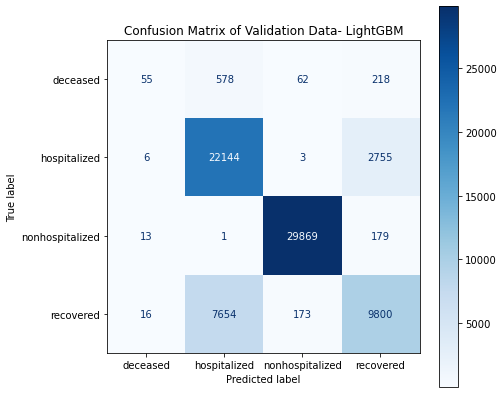

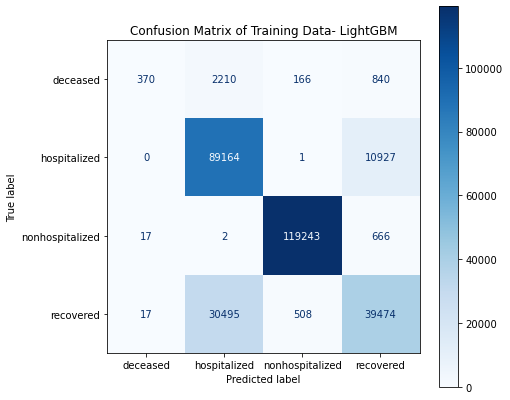

In [9]:
#fig, ax = plt.subplots(1,2,1)

fig, ax = plt.subplots(figsize=(7, 7))
#fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
metrics.plot_confusion_matrix(lgbm_model, validation_data, validation_truth,cmap=plt.cm.Blues,ax=ax, values_format = '.6g') 
ax.set_title('Confusion Matrix of Validation Data- LightGBM')

#fig, ax = plt.subplots(1,2,2)
fig, ax = plt.subplots(figsize=(7, 7))
metrics.plot_confusion_matrix(lgbm_model, training_data, training_truth,cmap=plt.cm.Blues, ax=ax, values_format = '.6g') 
#plt.tight_layout()  
ax.set_title('Confusion Matrix of Training Data- LightGBM')


In [43]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(validation_truth))]
# predict probabilities
lr_probs = lgbm_model.predict_proba(validation_data)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = metrics.roc_auc_score(validation_truth, ns_probs,multi_class='ovr')
lr_auc = metrics.roc_auc_score(validation_truth, lr_probs,multi_class='ovr')
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
# ns_fpr, ns_tpr, _ = metrics.roc_curve(validation_truth, ns_probs)
# lr_fpr, lr_tpr, _ = metrics.roc_curve(validation_truth, lr_probs)
# # plot the roc curve for the model
# pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
# pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# # axis labels
# pyplot.xlabel('False Positive Rate')
# pyplot.ylabel('True Positive Rate')
# # show the legend
# pyplot.legend()
# # show the plot
# pyplot.show()

AxisError: axis 1 is out of bounds for array of dimension 1

In [34]:
lr_probs

array([5.55892231e-06, 6.69741293e-01, 5.84308533e-01, ...,
       6.76392243e-06, 5.69904679e-01, 1.76669694e-06])